## Improting Required libraries

In [1]:
import mne
import matplotlib.pyplot as plt
import glob
import numpy as np

## Enabling CUDA use for MNE

In [2]:
mne.utils.set_config('MNE_USE_CUDA', 'true')

## Reading Dataset
We are reading four different kinds of datasets depicting 
- Heartfulness Meditation (htr)
- Concentration Meditation (ctr)
- Vipassana Meditation (vip)
- Sahaja Yoga Meditation (sny)

respectively.

In [3]:
%%capture

# # To avoid unneccesary writing

raw_data  =[]

# Types of data (for task-wise analysis)
data_we_need = ['015', '026', '062', '080']

# Getting data for task-wise analysis
for subject_number in data_we_need:
    for file in sorted(glob.glob('../sub-'+subject_number+'/eeg/*.bdf')):
        try:
            data = mne.io.read_raw_bdf(file, preload=True)
            times = data.times
            duration = times[-1] - times[0]
            # Getting onnly data greater than or equal to 10 minutes
            if duration >= 600:
                raw_data.append(data)
        except:
            print(name +" not loaded")

med1 = [0, 4, 8, 12]
med2 = [1, 5, 9, 13]
think1 = [2, 6, 10, 14]
think2 = [3, 7, 11, 15]

## Preprocessing Data
In this process, we will extract the necessary duration of data required and perform data cleaning to remove any artifacts.
- Referencing Data
- Dropping unnecessary channels
- Cropping data
- Filtering data (notch filter and bandpass filter)
- Applying ICA

In [4]:
%%capture

# Referencing data
raw_data  = [data.set_eeg_reference(ref_channels=['EXG8']) for data in raw_data]

In [5]:
# Dropping Channels
raw_data = [data.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4',
        'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']) for data in raw_data]

In [6]:
# Croping Data 
# Considering only first 10 minutes
cropped_raw_data = []

for files in raw_data:
    cropped_raw_data.append(files.crop(tmin=0.0, tmax=600.0))

### Downsampling data

In [7]:
%%capture

# Downsampling data to 256 Hz
raw_resampled = [raw_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for raw_data in cropped_raw_data]

In [8]:
# Preprocessing
# Cleaning the entire EEG 
def get_filtered_eeg(raw):
    low_freq = 0.3
    high_freq = 100.0

    raw_filtered = raw.copy().notch_filter(freqs=50)

    # Apply the bandpass filter
    raw_filtered = raw_filtered.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin', n_jobs="cuda")

    #ASR cleaning with cutoff=20
    # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
    # asr.fit(raw_filtered)
    # raw_filtered = asr.transform(raw_filtered)

    ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
    ica.fit(raw_filtered)

    # # ica.plot_components()

    ica.exclude = []
    # find which ICs match the EOG pattern; no EOG attached, Taking Fp1 as proxy
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered,ch_name="Fp1")
    ica.exclude = eog_indices
    ica.apply(raw_filtered)
    return raw_filtered

In [9]:
# Channels
np.array(raw_data[0].ch_names).reshape(1, 64)

array([['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
        'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
        'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
        'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
        'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
        'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
        'P10', 'PO8', 'PO4', 'O2']], dtype='<U3')

In [10]:
%%capture

# Filtering data
filtered_data = []

for data in raw_resampled:
    filtered_data.append(get_filtered_eeg(data))

Using matplotlib as 2D backend.


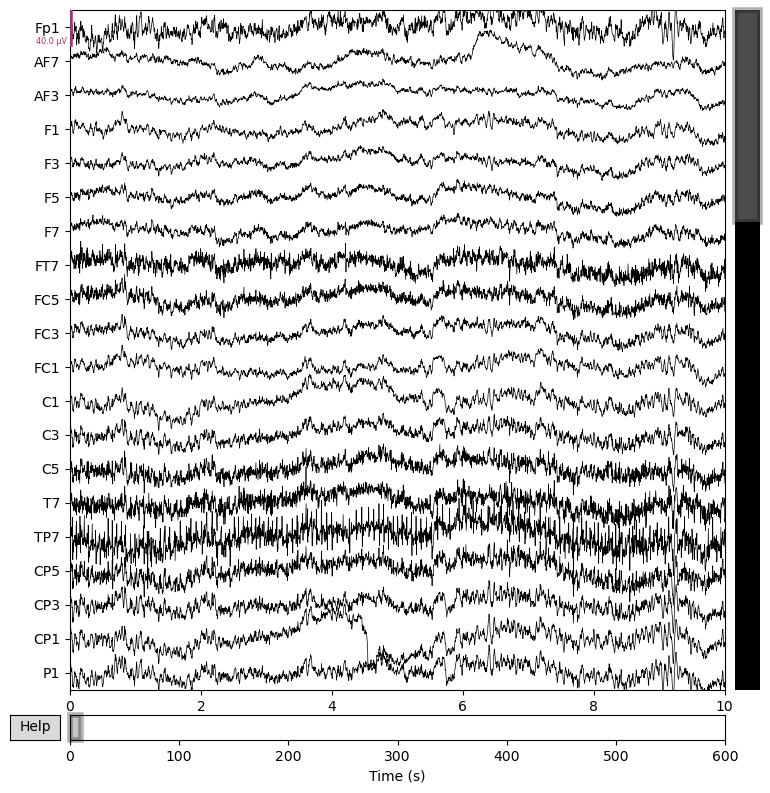

In [11]:
filtered_data[0].plot();

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_41671/2036467727.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)


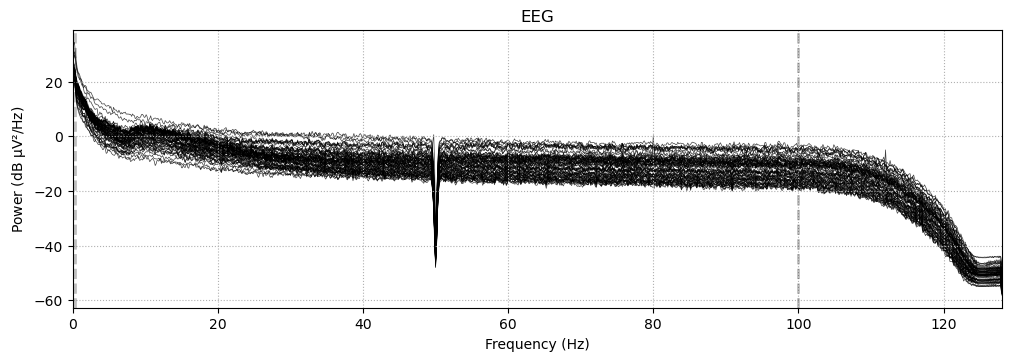

In [12]:
filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)

## Power Spectral Density(PSD)

In [13]:
%%capture

psdDatas, psdFreqs = [],  []
for i in med1:
    psdData, psdFreq = filtered_data[i].compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    psdDatas.append(psdData)
    psdFreqs.append(psdFreq)

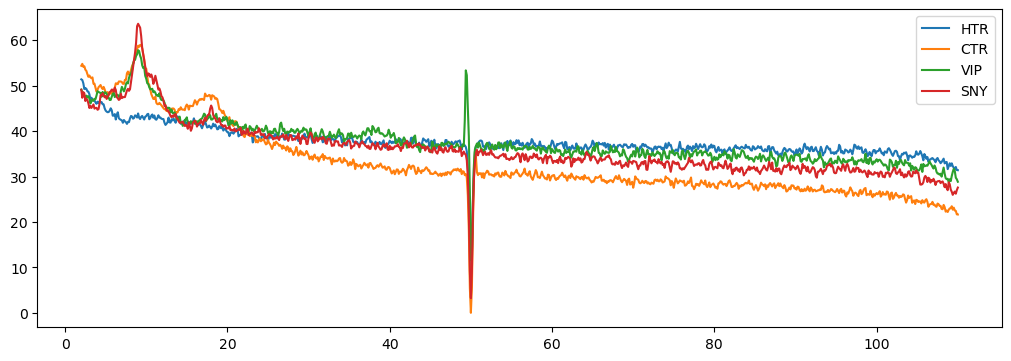

In [14]:
plt.clf()

shift_med1 = np.min([np.min(10*np.log10(psdDatas[0][0])), np.min(10*np.log10(psdDatas[1][0])), np.min(10*np.log10(psdDatas[2][0])), np.min(10*np.log10(psdDatas[3][0]))])
# Med1
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[1][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[3][0]) - shift_med1);
plt.legend([
    'HTR',
    'CTR',
    'VIP',
    'SNY'
])
plt.show();

## Removing pink noise
In this section, we will remove 1/f or pink or fatal noise from our data

In [15]:
def power_law(x, a, b):
    return a * (x ** (-b))

<Figure size 640x480 with 0 Axes>

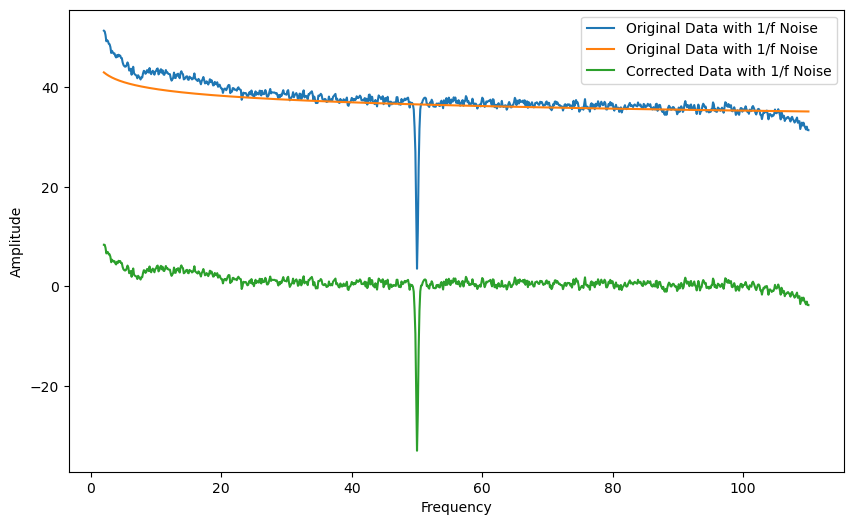

In [16]:
from scipy.optimize import curve_fit

# Select the tail region for fitting
tail_fraction = 0.6
tail_start_index = int((1 - tail_fraction) * len(psdFreqs[0]))

x_tail = psdFreqs[0][tail_start_index:]
y_tail = (10*np.log10(psdDatas[0][0]) - shift_med1)[tail_start_index:]

popt, _ = curve_fit(power_law, x_tail, y_tail)
a, b = popt

y_fit = power_law(psdFreqs[0], a, b)

# # Plot the fitted curve on top of the original data
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1, label='Original Data with 1/f Noise');
plt.plot(psdFreq, y_fit, label='Original Data with 1/f Noise');
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1 - y_fit, label='Corrected Data with 1/f Noise');
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show();


## Ploting power spectrum

<Figure size 640x480 with 0 Axes>

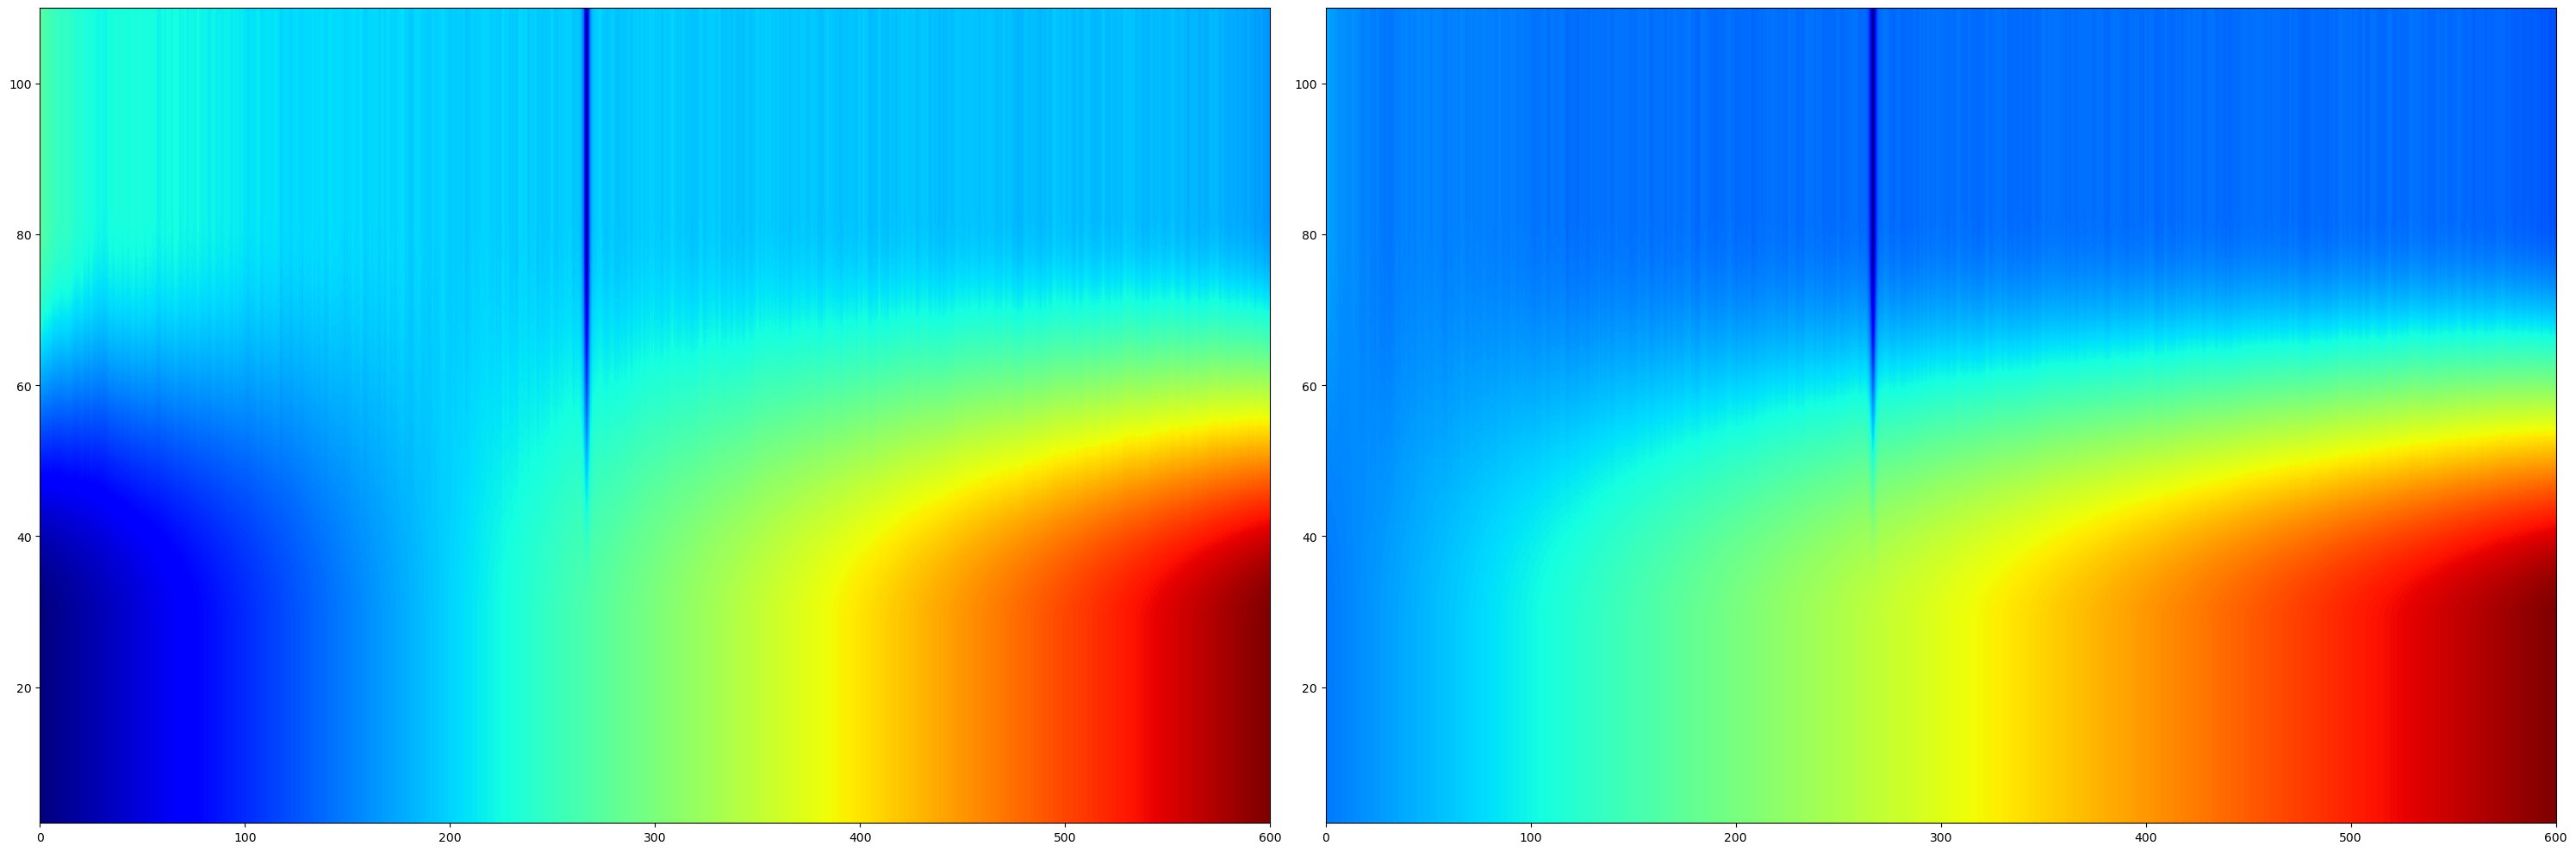

In [17]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10));
im1 = ax1.imshow((psdFreqs[0], (10*np.log10(psdDatas[0][0]) - shift_med1)),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
im2 = ax2.imshow((psdFreqs[0], 10*np.log10(psdDatas[0][0]) - shift_med1 - y_fit),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
plt.tight_layout()
plt.show()

## Connectivity

In [18]:
from mne_connectivity import spectral_connectivity_epochs

In [19]:
# Define parameters
epoch_length = 10.0  # in seconds
overlap = 0.5  # in seconds
sfreq = filtered_data[0].info['sfreq']  # sampling frequency
epoch_samples = int(epoch_length * sfreq)
overlap_samples = int(overlap * sfreq)

# Calculate the number of epochs
n_epochs = int((len(filtered_data[0]) - overlap_samples) / (epoch_samples - overlap_samples))

# Generate events
events = np.array([[i * (epoch_samples - overlap_samples), 0, 1] for i in range(n_epochs)])

In [20]:
%%capture

# Create epochs
epochs = [mne.Epochs(data, events, event_id=1, tmin=0, tmax=epoch_length, baseline=None, preload=True) for data in filtered_data]

In [21]:
np.array(epochs[0]).shape

(63, 64, 2561)

<Figure size 640x480 with 0 Axes>

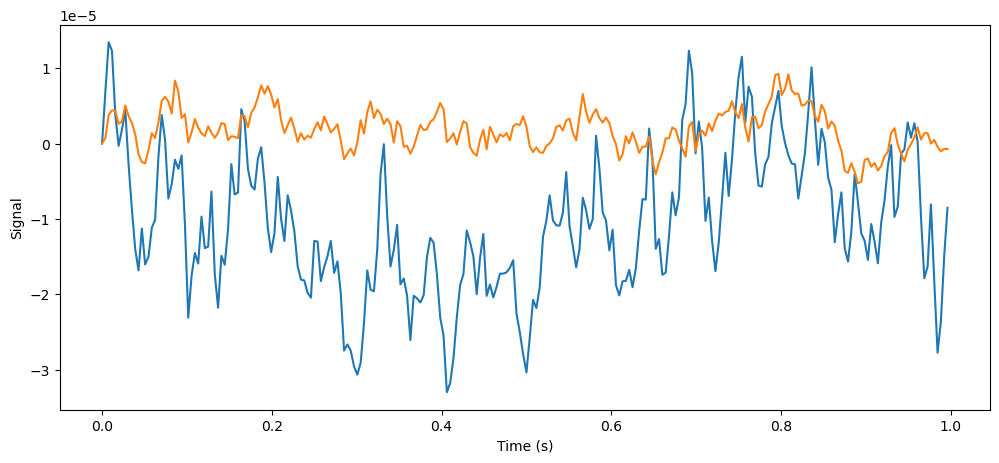

In [22]:
fs = 256

t = np.arange(0, epoch_length, 1 / fs)

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharey=True)
ax.plot(t[:fs], np.array(epochs[0])[0, 0, :fs], label="Reference");        #EXG8 reference
ax.plot(t[:fs], np.array(epochs[0])[0, 2, :fs]);

ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal")

plt.show();

In [23]:
# Frequecy bands of interest
Freq_bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
n_freq_bands = len(Freq_bands)
min_freq = np.min(list(Freq_bands.values()))
max_freq = np.max(list(Freq_bands.values()))

In [24]:
# Freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq)) * 4 + 1)

In [25]:
# Getting minimum frequecy for each band
fmin = tuple([list(Freq_bands.values())[i][0] for i in range(n_freq_bands)])
fmax = tuple([list(Freq_bands.values())[f][1] for f in range(len(Freq_bands))])

In [26]:
# Connectivity methods
# Allocate memory for connectivity matrices
con_matrix = np.zeros((
    len(raw_data[0].ch_names), len(raw_data[0].ch_names), n_freq_bands, np.array(epochs[0]).shape[2]
))
# nan matrix
con_matrix [con_matrix == 0] = np.nan

In [27]:
fmin, fmax

((4.0, 8.0, 13.0), (8.0, 13.0, 30.0))

In [28]:
epochs[0]

Number of events,63
Events,1: 63
Time range,0.000 – 10.000 s
Baseline,off


In [29]:
conn_epochs = spectral_connectivity_epochs(
    epochs[0], method='coh', mode='cwt_morlet', sfreq=256, cwt_freqs=freqs, fmin=(4.0, 8.0, 13.0), fmax=(8.0, 13.0, 30.0), faverage=True)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=0.000s..10.000s for estimation (2561 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..8.0Hz (17 points)
     band 2: 8.0Hz..13.0Hz (21 points)
     band 3: 13.0Hz..30.0Hz (69 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spect

In [30]:
# Get data as connectivity matrices
con_matrix = conn_epochs.get_data(output="dense")
con_matrix.shape

(64, 64, 3, 2561)

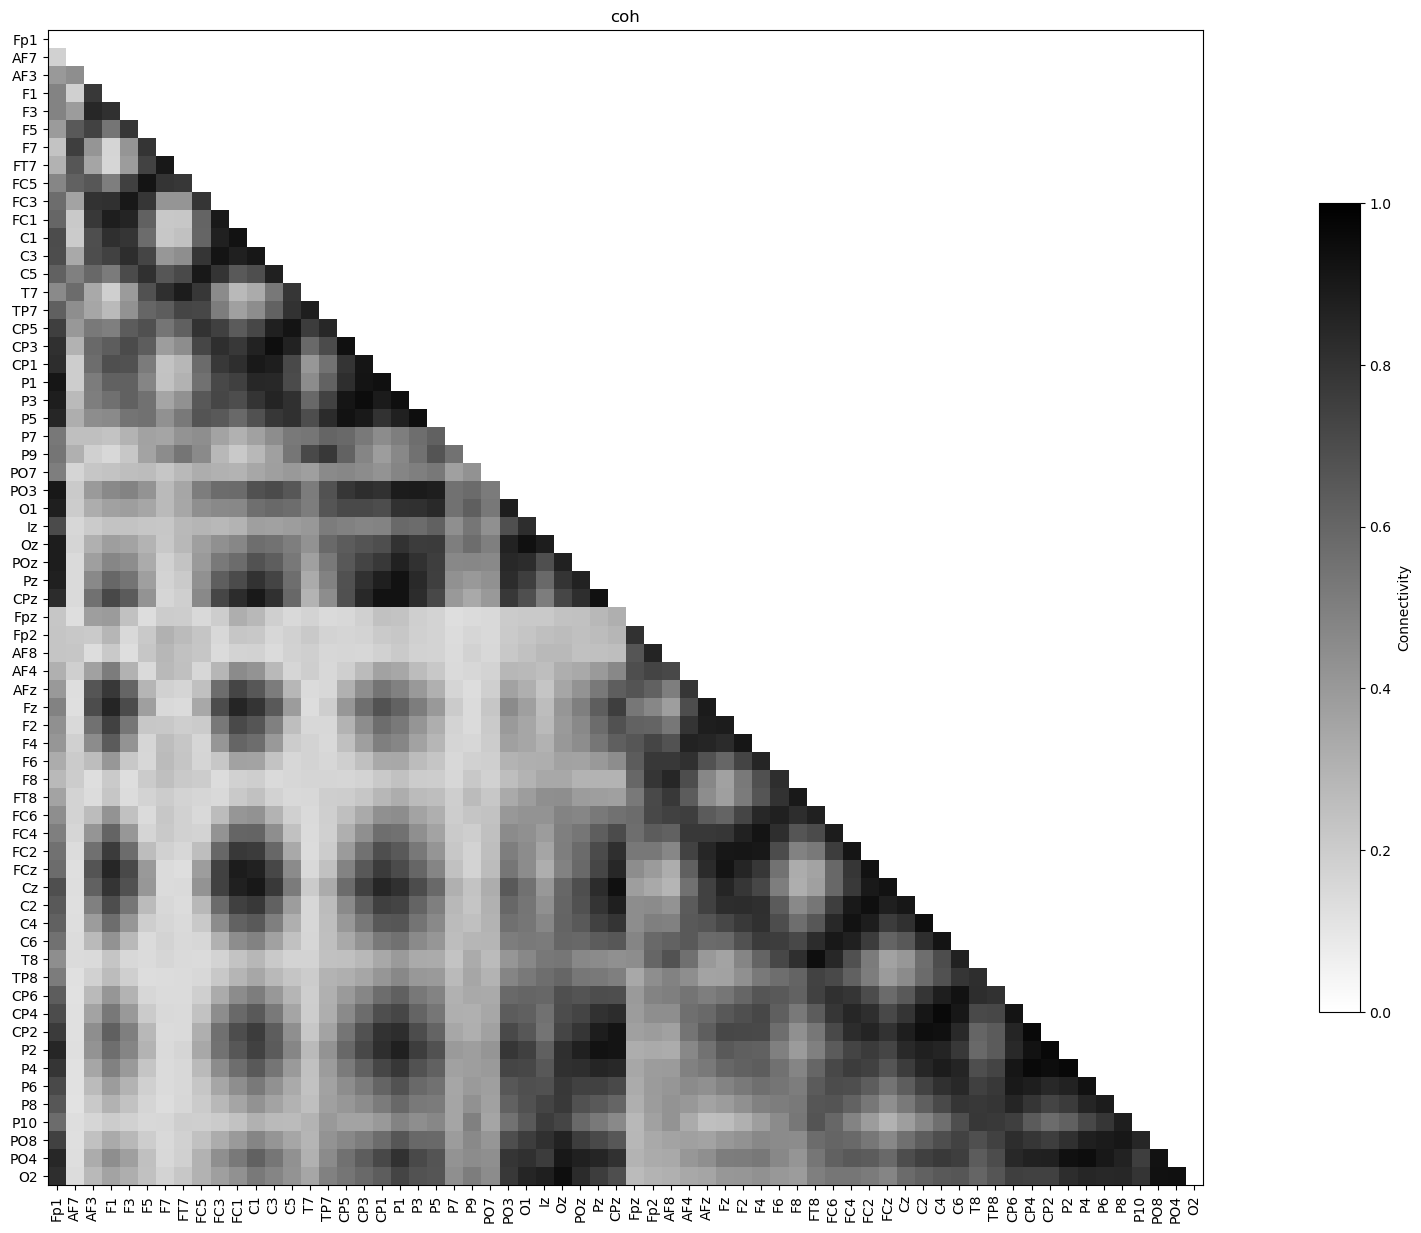

In [31]:
con_epochs_array = np.mean(con_matrix, axis=3)  # average over timepoints

# In this example, we will just show alpha
foi = list(Freq_bands.keys()).index("alpha")  # frequency of interest


# Define function for plotting con matrices
def plot_con_matrix(con_data):
    """Visualize the connectivity matrix."""
    fig, ax = plt.subplots(1, 1, figsize=(30, 15))
    # Plot with imshow
    con_plot = ax.imshow(con_data[:, :, foi], cmap="binary", vmin=0, vmax=1)
    # Set title
    ax.set_title('coh')
    # Add colorbar
    fig.colorbar(con_plot, ax=ax, shrink=0.7, label="Connectivity")
    # Fix labels
    ax.set_xticks(range(len(raw_data[0].ch_names)))
    ax.set_xticklabels(raw_data[0].ch_names, rotation=90)
    ax.set_yticks(range(len(raw_data[0].ch_names)))
    ax.set_yticklabels(raw_data[0].ch_names)
    return fig


plot_con_matrix(con_epochs_array)

In [57]:
# Canonical Coherence based connectivity

seeds = [0, 1, 2, 6, 7, 8]
targets = [3, 4, 5, 9, 10, 11]
multivar_indices = ([seeds], [targets])

# Compute MIC
mic = spectral_connectivity_epochs(
    epochs[0], method='mic', indices=multivar_indices, sfreq=100, fmin=3, fmax=35
)


Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..10.000s for estimation (2561 points)
    frequencies: 3.1Hz..35.0Hz (320 points)
Estimated data ranks:
    connection 1 - seeds (6); targets (6)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: MIC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross

  0%|          | frequency blocks : 0/320 [00:00<?,       ?it/s]

[Connectivity computation done]


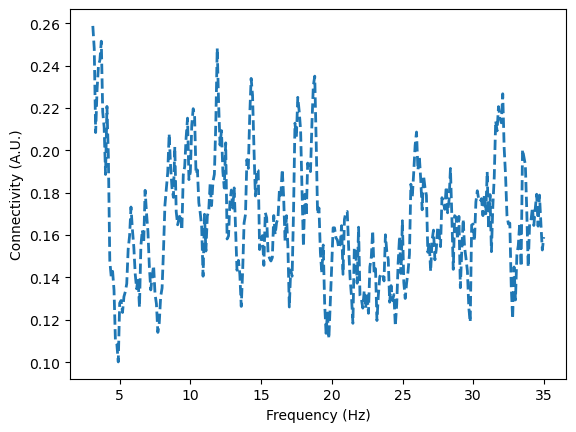

In [55]:
fig, axis = plt.subplots(1, 1);
axis.plot(
    mic.freqs, np.abs(mic.get_data()[0]), linewidth=2, label="MIC", linestyle="--"
);
axis.set_xlabel("Frequency (Hz)");
axis.set_ylabel("Connectivity (A.U.)");
plt.show();